# Correlation of vertex betweenness with graph energy of vertex egocentric network

In this experiment we are considering the measure of energy dispersion and its correlation to betweeness of vertices. There are multiple graph energies proposed in the literature, but our primary interest lies in Graph and Randić energies. Within the experiment we calculate the energy of each vertex by means of their ego-network. Then we compare how betweenes of vertices is correlated with the energy of their egocentric networks.

Our second experiment aims at using machine learning to predict the betweenness of a vertex from only the local information contained in the egocentric network of that vertex. Computing of betweenness requires a very costly computation of all shortest paths in the network. Our approach allows to estimate betweennes using only local information.

Finally, in our third experiment, we perform transfer learning, training a model for predicting betweenness on one network, and using this model to predict betweenness of vertices in other networks.


### Graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm_notebook as tqdm

from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import logging
import requests
import itertools

In [3]:
import sys
sys.path.append("..")

import network_energy as ne

In [4]:
def chunks(lst, n):
    """
    Divide a list of vertices `lst` into chunks consisting of `n` vertices
    
    Tests:
    >>> list(chunks([1,2,3,4,5,6], 2))
    [(1, 2), (3, 4), (5, 6)]

    >>> list(chunks([1,2,3,4,5,6], 4))
    [(1, 2, 3, 4), (5, 6)]

    >>> list(chunks([], 2))
    []

    """
    _lst = iter(lst)
    while 1:
        x = tuple(itertools.islice(_lst, n))
        if not x:
            return
        yield x
        
def normalize_df_column(df_column):
    """
    Normalize a dataframe column to the range [0,1]
    
    Tests:
    >>> normalize_df_column(pd.Series([1,2,3,4,5]))
    array([[0.  ],
           [0.25],
           [0.5 ],
           [0.75],
           [1.  ]])
    """
    x = df_column.values.astype(float)
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    
    return x_scaled

In [5]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=4)

# Experiment 1

## Correlation of graph/Randić energy and betweenness in artificial networks

In this experiment we create several instances of networks generated by two popular models:

- Erdos-Renyi random network model
- Barabasi-Albert preferential attachment model

and for each network we modify its main generative parameter. For each network we collect detailed statistics on every node:

- its betweenness,
- its Randić energy,
- and its graph energy.

We normalize these variables using MinMax scaling to the range of [0-1]. Finally, we group the data by network model and network model parameter used to generate a given network instance, and for each such combination we compute the correlation of 



In [6]:
num_nodes=100

results = pd.DataFrame(columns=['node', 
                                'betweenness', 
                                'randic_energy', 
                                'graph_energy', 
                                'network_model', 
                                'network_model_param'])

# iterate over different parameter settings
network_model_params = [p/100 for p in range(1,50, 2)]

for p in tqdm(network_model_params):

    # generate random and power-laww networks with n=100 and p=0.01, 0.03, 0.05, ...
    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p)
    }
    
    for generator in generators.keys():
        
        G = generators[generator]
        
        be = nx.betweenness_centrality(G, k=None)
        re = ne.randic_centrality(G)
        ge = ne.graph_energy_centrality(G)
        
        _dict = {
            'node': list(G.nodes),
            'betweenness': list(be.values()),
            'randic_energy': list(re.values()),
            'graph_energy': list(ge.values()),
            'network_model': [generator] * G.number_of_nodes(),
            'network_model_param': [p] * G.number_of_nodes()
        }
        
        _result = pd.DataFrame.from_dict(_dict)
        
        results = pd.concat([results, _result], axis=0)

In [7]:
# normalize columns to the range [0,1]

results.betweenness = normalize_df_column(results.betweenness)
results.randic_energy = normalize_df_column(results.randic_energy)
results.graph_energy = normalize_df_column(results.graph_energy)

In [8]:
# what is the correlation between betweenness and randić energy for different models?
_results = results.groupby(
    ['network_model_param','network_model'])[['betweenness','randic_energy', 'graph_energy']].corr().reset_index()

# extract correlations for the two models
powerlaw_idx = _results['network_model'] == 'powerlaw'
random_idx = _results['network_model'] == 'random'

powerlaw_corr = _results[powerlaw_idx]['betweenness'].tolist()
random_corr = _results[random_idx]['betweenness'].tolist()

# get additional columns with network model parameter and type of energy
network_model_param = _results[random_idx]['network_model_param'].tolist()
energy_idx = _results[random_idx]['level_2'].tolist()

correlations = pd.DataFrame({'p': network_model_param, 
                             'energy': energy_idx,
                             'powerlaw': powerlaw_corr, 
                             'random': random_corr})

# melt the DataFrame to a format more suitable for drawing
correlations_mlt = pd.melt(correlations[correlations['energy'] != 'betweenness'], 
                id_vars=['p','energy'], 
                value_vars=['powerlaw','random'], 
                var_name='network_model', 
                value_name='correlation')

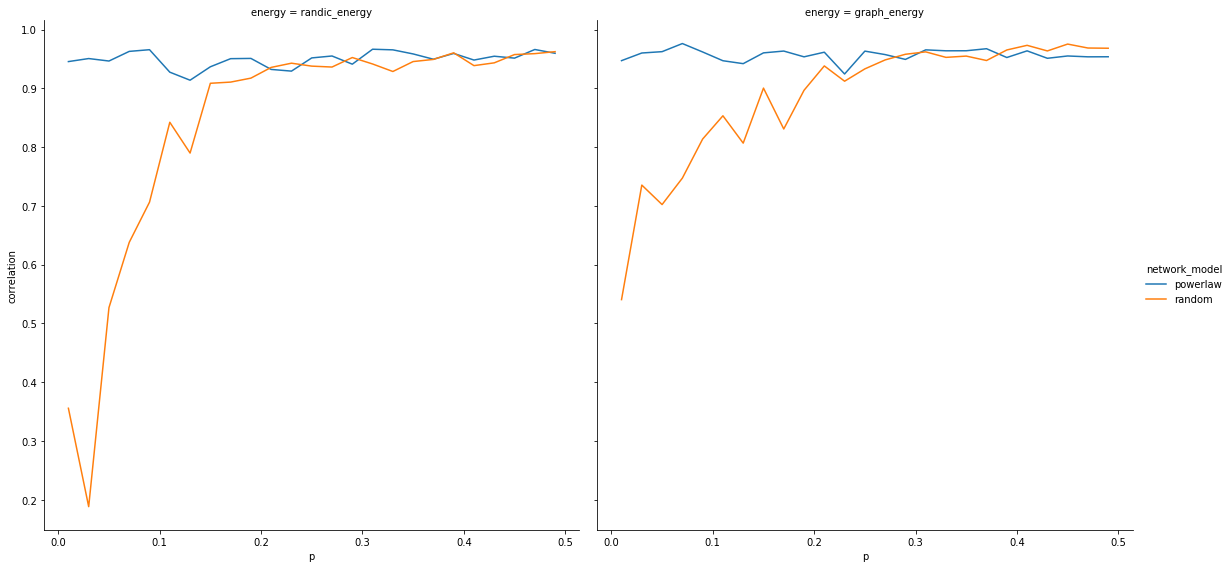

In [9]:
g = sns.FacetGrid(correlations_mlt, col='energy', hue='network_model', height=8)
g.map(sns.lineplot, 'p', 'correlation')
g.add_legend()

# Experiment 2

## Visualization of Randić energy

Two artificial networks are generated according to the following models:

- Erdos-Renyi random network model
- Barabasi-Albert preferential attachment network

For both networks we visualize the value of Randić energy of each vertex by its color and size. Parameters of both generators were set arbitrarily since the only purpose of this figure is to illustrate the overall distribution of Randić energy.

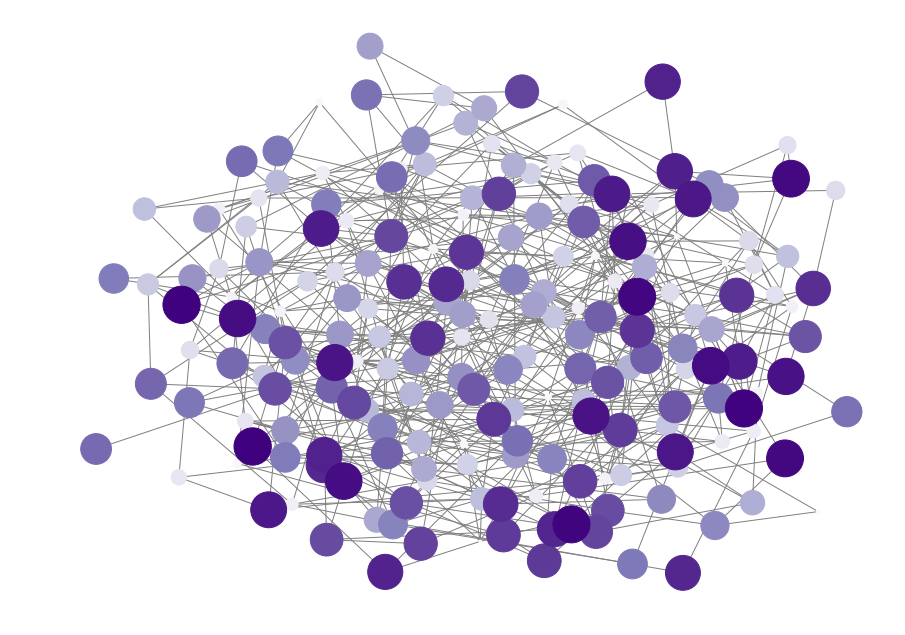

In [12]:
g = nx.erdos_renyi_graph(n=200, p=0.03)

re = ne.randic_centrality(g)

options = { 
    'node_color': [d * 1 for d in list(re)], 
    'node_size': [d * 7 for d in list(re)], 
    'cmap': plt.cm.Purples,
    'edge_color': 'gray' 
}

sns.set(rc={'figure.figsize':(11.7,8.27)})
nx.draw_kamada_kawai(g, **options)

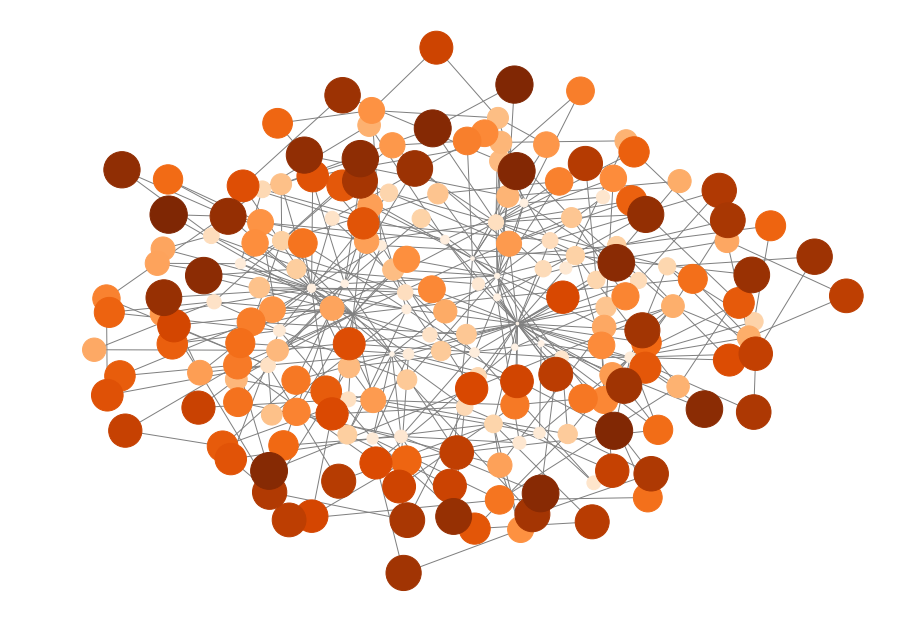

In [13]:
g = nx.powerlaw_cluster_graph(n=200, p=0.25, m=2)

re = ne.randic_centrality(g)

options = { 
    'node_color': [d * 1 for d in list(re)], 
    'node_size': [d * 7 for d in list(re)], 
    'cmap': plt.cm.Oranges,
    'edge_color': 'gray' 
}

sns.set(rc={'figure.figsize':(11.7,8.27)})
nx.draw_kamada_kawai(g, **options)

# Experiment 3

## Regression modeling on synthetic networks

As the next step we fit regression models and compute their accuracy in terms of

  * Pearson, Spearman, and Kendall correlations
  * mean absolute error
  * mean squarred error
  
In the experiment we fit various regressors:

- simple linear model
- random forest regressor
- gradient boosting regressor

We collect the data from generative network models, and for each vertex we note its betweenness and its energies. Then, we fit these three regressors for networks generated for a particular value of the generative attribute.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata

regression_models = {
    'linear model': LinearRegression(), 
    'random forest': RandomForestRegressor(), 
    'gradient boosting': GradientBoostingRegressor()
}

prediction_results = []

for network_model in results['network_model'].unique():
    for network_model_param in network_model_params:
        
        model_idx = results['network_model'] == network_model
        param_idx = results['network_model_param'] == network_model_param
        
        df = results[ model_idx & param_idx]
        
        y = df['betweenness'].values
        X = df[['randic_energy','graph_energy']].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
        for regression_model in regression_models:
            
            l_model = regression_models[regression_model]
            
            l_model.fit(X=X_train, y=y_train)
            y_pred = l_model.predict(X_test)

            y_ranked = rankdata(y_test, method='ordinal') 
            y_pred_ranked = rankdata(y_pred, method='ordinal')

            _dict = {
                'regression_model': regression_model,
                'network_model': network_model,
                'network_model_param': network_model_param,
                'mae': mean_absolute_error(y_true=y_test, y_pred=y_pred),
                'mse': mean_squared_error(y_true=y_test, y_pred=y_pred),
                'r2': r2_score(y_test, y_pred),
                'pearson': pearsonr(y_test, y_pred)[0],
                'spearman': spearmanr(y_test, y_pred, axis=0, nan_policy='propagate')[0],
                'kendall': kendalltau(y_ranked, y_pred_ranked, initial_lexsort=None, nan_policy='propagate')[0]
            }

            prediction_results.append(_dict)

# convert the list of dicts into a DataFrame
prediction_results = pd.DataFrame(prediction_results, 
             columns=['regression_model', 
                      'network_model',
                      'network_model_param', 
                      'mae', 
                      'mse', 
                      'r2', 
                      'pearson', 
                      'spearman', 
                      'kendall'])

# melt DataFrame to transform it into tidy format
prediction_results_mlt = pd.melt(prediction_results,
                             id_vars=['regression_model', 'network_model','network_model_param'], 
                             var_name='measure',
                             value_name='value')

## Visualization of the relationship between betweenness and energies in synthetic networks

The following figures show the linear model predicting vertex betweenness based on graph energy and Randić energy for random and powerlaw networks for a fixed value of the generative parameter. The value of the parameter is drawn randomly from the entire domain of the parameter.

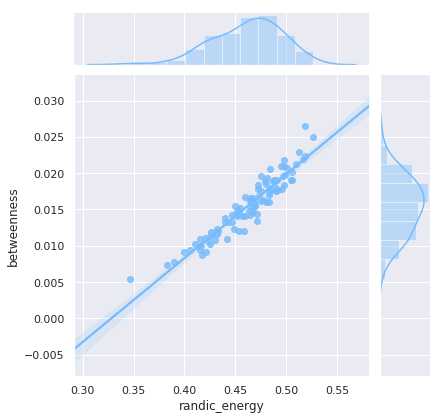

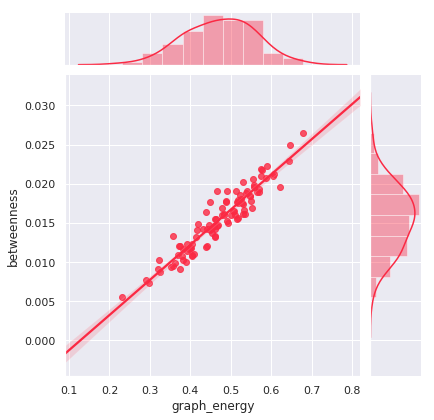

In [18]:
network_model = 'random'
network_model_param = np.random.choice(network_model_params)

sns.jointplot(x='randic_energy', 
              y='betweenness', 
              data=results[(results['network_model'] == network_model) 
                           & (results['network_model_param'] == network_model_param)], 
              kind='reg', 
              color="xkcd:sky blue")

sns.jointplot(x='graph_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model) 
                           & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:strawberry")

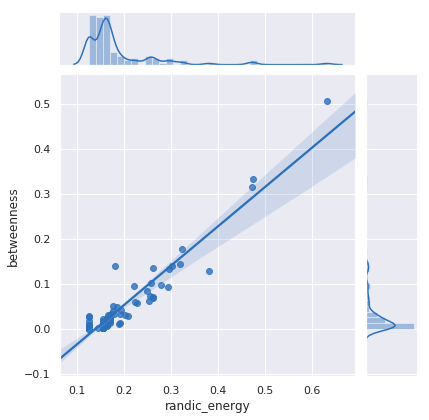

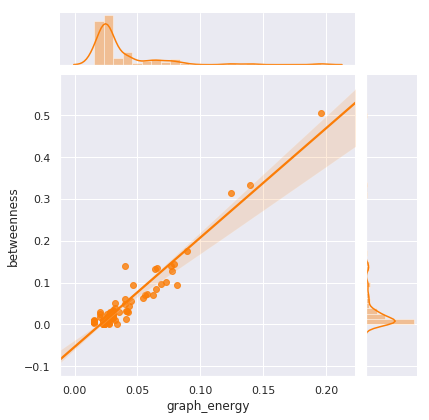

In [19]:
network_model = 'powerlaw'
network_model_param = np.random.choice(network_model_params)

sns.jointplot(x='randic_energy', 
              y='betweenness', 
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind='reg', 
              color="xkcd:medium blue")

sns.jointplot(x='graph_energy', 
              y='betweenness',
              data=results[(results['network_model'] == network_model)
                          & (results['network_model_param'] == network_model_param)], 
              kind="reg", 
              color="xkcd:pumpkin orange")

Below we present correlation measures (Pearson, Spearman, Kendall) which describe the relationship of betweenness and vertex energies (Randic and graph)

In [20]:
result = []

for network_model in results.network_model.unique():
    for network_model_param in network_model_params:

        network_model_idx = results['network_model'] == network_model
        network_model_param_idx = results['network_model_param'] == network_model_param

        for method in ['kendall','spearman','pearson']:

            _corr = results[network_model_idx & network_model_param_idx][
                ['betweenness',
                 'randic_energy',
                 'graph_energy']].corr(method=method)
            
            result.append((network_model, 
                           network_model_param, 
                           method, 
                           _corr.betweenness['randic_energy'], 
                           _corr.betweenness['graph_energy']))
        
correlations = pd.DataFrame(result, 
                            columns=['network_model', 
                                     'network_model_param',
                                     'method', 
                                     'BRC', 
                                     'BGC'])

# print(correlations.to_latex(index=False))

In [21]:
# melt DataFrame to transform it into tidy format
correlations_mlt = pd.melt(correlations,
                             id_vars=['network_model','network_model_param', 'method'], 
                             var_name='measure',
                             value_name='correlation')

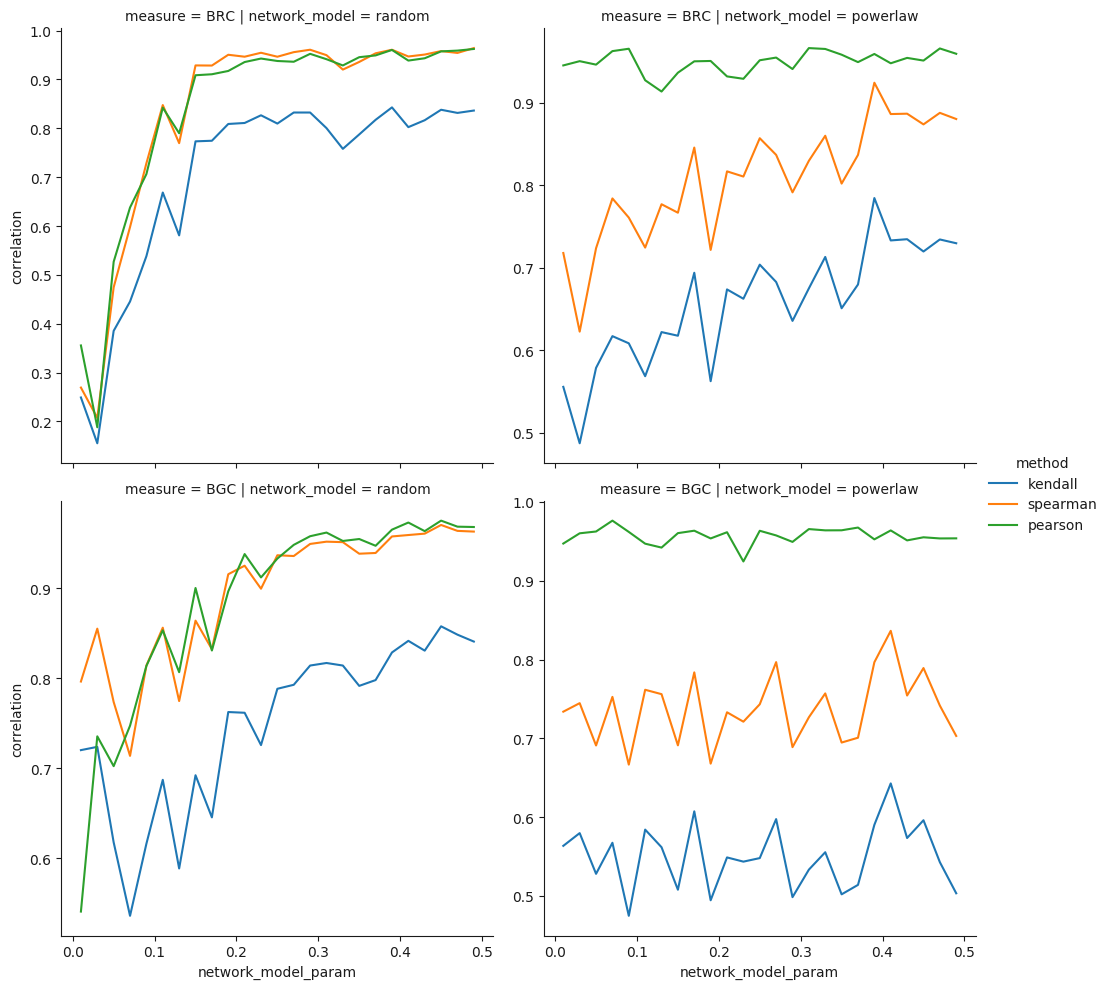

In [22]:
sns.reset_defaults()

g = sns.FacetGrid(correlations_mlt, col='network_model', row='measure', hue='method', height=5, sharey=False)
g.map(sns.lineplot, 'network_model_param', 'correlation')
g.add_legend()

# Experiment 4

## empirical networks

In this experiment we are trying to verify if the relationship between vertex energies and vertex betweenness holds also in empirical networks. We download a set of networks from the Koblenz network repository and compute the basic statistics of these networks.

In [23]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import os
import shutil
import time

In [24]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [25]:
networks_names=[
 'moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
]

In [26]:
networks=[]

for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name))

ConnectionError: HTTPConnectionPool(host='konect.uni-koblenz.de', port=80): Max retries exceeded with url: /downloads/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f44fe8644e0>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [ ]:
network_stats = []

for (name, network) in zip(networks_names, networks):
    network_stats.append((name, 
                          network.number_of_nodes(), 
                          network.number_of_edges(),
                          np.round(network.number_of_edges()/network.number_of_nodes(), 2)))
    
df = pd.DataFrame(network_stats, columns=['network name', 'number of vertices', 'number of edges', 'average degree'])

print(df.to_latex(index=False))

In [ ]:
x = range(1,100)
y1 = np.power(x*np.log(x), 1/3)
y2 = np.power(x, 2/3)

df = pd.DataFrame({
    'num vertices': x,
    'best limit': y1,
    'naive limit': y2
}).melt(id_vars=['num vertices'], var_name='average degree limit')

sns.set(rc={'figure.figsize':(11.7,8.27)})


figure = sns.lineplot(data=df, x='num vertices', y='value', hue='average degree limit')

plt.xlabel('number of vertices')
plt.ylabel('average vertex degree')

plt.show(figure)

Firstly we calculate betweenness and energy measures for each vertex

In [ ]:
real_data_measures = pd.DataFrame(columns=['node', 'value_type','value','network'])

for i in tqdm(range(len(networks))):
    G = networks[i]
    
    be = calculate_betweenes(G, k=None)
    tmp_df = pd.DataFrame({'node': [i[0] for i in be.items()],
                         'value_type': ['betweenness' for i in be.items()],
                         'value': [i[1] for i in be.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value'] = normalize_df_column(tmp_df['value'])
    real_data_measures = pd.concat([real_data_measures,tmp_df])
        
        
    re = calculate_randic_energy(G)
    tmp_df = pd.DataFrame({'node': [i[0] for i in re.items()],
                         'value_type': ['randic' for i in re.items()],
                         'value': [i[1] for i in re.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value'] = normalize_df_column(tmp_df['value'])
    real_data_measures = pd.concat([real_data_measures, tmp_df])

    ge = calculate_graph_energy(G)
    tmp_df = pd.DataFrame({'node': [i[0] for i in ge.items()],
                         'value_type': ['graph' for i in ge.items()],
                         'value': [i[1] for i in ge.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value'] = normalize_df_column(tmp_df['value'])
    real_data_measures = pd.concat([real_data_measures, tmp_df])

In [ ]:
real_data_measures.to_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

In [ ]:
def evaluate_results(net, y, y_pred):
    
    real_prediction_results = pd.DataFrame(columns=['network', 'error_type', 'error_value'])
    
    mae = sklearn.metrics.mean_absolute_error(y_true=y, y_pred=y_pred)
    tmp_df = pd.DataFrame({'network': [net],
                         'error_type': ['MAE'], 
                         'error_value': [mae]
                        })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    mse = sklearn.metrics.mean_squared_error(y_true=y, y_pred=y_pred)
    tmp_df = pd.DataFrame({'network': [net],
                         'error_type': ['MSE'], 
                         'error_value': [mse]
                        })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    pearson,_ = scipy.stats.pearsonr(x=y,y=y_pred)
    tmp_df = pd.DataFrame({'network': [net],
                         'error_type': ['pearson'], 
                         'error_value': [pearson]
                        })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])

    spearman,_ = scipy.stats.spearmanr(a=y,b=y_pred, axis=0, nan_policy='propagate')
    tmp_df = pd.DataFrame({'network': [net],
                         'error_type': ['spearman'], 
                         'error_value': [spearman]
                        })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])


    y_ranked = scipy.stats.rankdata(y, method='ordinal') #może metoda average
    y_pred_ranked = scipy.stats.rankdata(y_pred, method='ordinal')

    kendall,_ = scipy.stats.kendalltau(x=y_ranked,y=y_pred_ranked, initial_lexsort=None, nan_policy='propagate')
    tmp_df = pd.DataFrame({'network': [net],
                         'error_type': ['kendall'], 
                         'error_value': [kendall]
                        })
    real_prediction_results = pd.concat([real_prediction_results, tmp_df])    
    
    return real_prediction_results

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

real_prediction_results = pd.DataFrame(columns=['network', 'error_type', 'error_value'])
models = []

real_data_measures = pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')


for net in tqdm(real_data_measures['network'].unique()):

        l_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
        l_model = RandomForestRegressor()
    
        y = real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values

        X = real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        l_model.fit(X_train.reshape(-1, 1), y_train)

        models.append(l_model)
        
        y_pred=l_model.predict(X_test.reshape(-1, 1))
        
        real_prediction_results=pd.concat([real_prediction_results,evaluate_results(net,y_test,y_pred)])
        
        
real_prediction_results.to_pickle('./real_prediction_results_errors.pickle')     

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

real_prediction_results=pd.read_pickle('./real_prediction_results_errors.pickle') 

f, axs = plt.subplots(5, 1, figsize=(10, 28), sharex=True, sharey=False)

for error_type, ax in zip(real_prediction_results['error_type'].unique(),axs):
    
    x = real_prediction_results[real_prediction_results['error_type']==error_type]['network'].values
    y = real_prediction_results[real_prediction_results['error_type']==error_type]['error_value'].values
    
    colors = {'MAE': 'xkcd:salmon',
              'MSE': 'xkcd:pea green', 
              'pearson': 'xkcd:sky blue', 
              'spearman': 'xkcd:goldenrod', 
              'kendall': 'xkcd:moss green'}
    
    plt.ylim([0,1])    
    ax.set_xticklabels(x,rotation='vertical')
    ax.set_title(error_type, fontsize=18)
    ax.set(xlabel='Network', ylabel='Value')
    sns.barplot(x, y, ax=ax, color=colors[error_type])
    
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)


In [ ]:
df = pd.pivot_table(real_prediction_results.round(2), 
                    index='network', 
                    columns='error_type', 
                    values='error_value').rename_axis(None, axis=1)
print(df.to_latex())

### Third experiment: Transfer learning

In this experiment we check if it is possible to train the linear model on one network and then transfer the same model to other networks. In other words, if the relationship between vertex betweenness and vertex energy is universal, such transfer learning should be possible.

In [ ]:
real_data_measures=pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

transfer_real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value', 'source_network'])

raw_results=pd.DataFrame(columns=['network', 'source_network', 'y', 'y_pred'])


for i in tqdm(range(len(models))):
    for net in (real_data_measures['network'].unique()):
        y=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values

        X=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values
        
        y_pred=models[i].predict(X.reshape(-1, 1))
        
        eval_res=evaluate_results(net,y,y_pred)
        eval_res['source_network']=networks_names[i]
        
        raw_results=pd.concat([raw_results, pd.DataFrame.from_dict({'network': net, 'source_network': networks_names[i], 'y': y, 'y_pred':y_pred})])
        
        transfer_real_prediction_results=pd.concat([transfer_real_prediction_results,eval_res])

lets draw heatmap

In [ ]:
sns.set_style("whitegrid")
sns.set_palette('Oranges')
sns.set_context("notebook", font_scale=1.8)

for error_type in ['MAE', 'MSE']:
    
    x=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    y=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()

    val=np.array(transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['error_value'])
    val=val.reshape(len(x),len(y))

    plt.figure(figsize=(15,15))
    plt.title(error_type)
    
    to_draw=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]
    
    ax = sns.heatmap(to_draw[['error_value', 
                              'source_network', 
                              'network']].pivot('source_network','network','error_value'), linewidth=0.5, cmap='Oranges')
    ax.invert_yaxis()
    
    plt.show()
    

In [ ]:
for error_type in ['pearson', 'spearman', 'kendall']:
    
    x=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    y=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()

    val=np.array(transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['error_value'])
    val=val.reshape(len(x),len(y))

    plt.figure(figsize=(15,15))
    plt.title(error_type)
    
    to_draw=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]
    
    ax = sns.heatmap(to_draw[['error_value', 
                              'source_network', 
                              'network']].pivot('source_network','network','error_value'), linewidth=0.5, cmap='Oranges_r')
    ax.invert_yaxis()
    
    plt.show()
    

#### Summary: 
- all (obviously with some variance) networks have high correlations between Randić energy of ego networks and betweeness

### Available datasets from KONECT

In [ ]:
read_avalilable_datasets_konect()


# Plan eksperymentu (PL)
- wyliczenie dla wszystkich wierzchołków sieci ich pośrednictwa, pośrednictwa szacowanego na podstawie ścieżek o długości 2, 3, ..., k, oraz energii macierzy sąsiedztwa w sieci egocentrycznej
- wyznaczenie prostej regresji liniowej m/y pośrednictwem i energią wierzchołka, miarami jakości mogą być:
  * korelacja Pearsona
  * korelacja Spearmana
  * korelacja Kendalla
  * błąd bezwzględny (po normalizacji obu miar)
  * błąd średniokwadratowy (po normalizacji obu miar)
- do porównania bierzemy wynik na podstawie energii i porównujemy z wynikiem na podstawie estymacji pośrednictwa
- zamiast prostej regresji możemy nauczyć model, korzystając z następujących cech:
  * energia macierzy sąsiedztwa sieci egocentrycznej wierzchołka
  * min/avg/max energii macierzy sąsiedztwa sąsiadów wierzchołka

- jako dodatkowy bonus możemy pokazać, że w przypadku energii następuje transfer learning, tzn. możemy nauczyć model raz na jednej instancji sieci i wyznaczyć jego dokładność dla całego zbioru sieci po podobnej topologii, ale nieco innych parametrach (zakładając, że wierzchołki nie mają tożsamości, nie da się takiego transferu przeprowadzić innymi metodami)